# Generates Rollout for existing Checkpoint

This notebook will demonstrate the clean usage of the `track_mjx.analysis.rollout` module, which allows user to load the checkpoint from the previous training run, and perform a rollout of the checkpoint. This module abstracted away all the boilerplate codes for initializing the environment, and it is very clean and digestible, while customizable.

## Step 1: Imports and recover the config

In [23]:
# set environment variables for rendering
    
%env MUJOCO_GL=egl
%env PYOPENGL_PLATFORM=egl
%matplotlib inline
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf
from track_mjx.analysis.rollout import (
    restore_config,
    create_rollout_generator,
    create_environment,
    create_inference_fn,
)
from jax import numpy as jp
import multiprocessing as mp
import functools
from tqdm import tqdm
import numpy as np

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# save and load
from track_mjx.analysis.utils import save_to_h5py, load_from_h5py, get_aggregate_data, extract_clip_info
import h5py

# load snipp label
import pickle as pkl

# render
from track_mjx.analysis.render import (
    render_from_saved_rollout,
    display_video,
    render_with_global_and_local_pca_progression,
    plot_height_based_gait_analysis,
    plot_homology,
    plot_intrinsic,
    estimate_joint_forces_parallel,
    plot_height_based_gait_analysis,
    plot_force_based_gait_analysis,
    estimate_ground_forces_per_joint,
    plot_grf_based_gait_analysis_per_joint
)

# recover the config
ckpt_path = "/root/vast/scott-yang/track-mjx/model_checkpoints/rodent_data/ReferenceClip.p_250127_062443"  # replace with your checkpoint path
config = restore_config(ckpt_path)
cfg = OmegaConf.create(config)

# make some changes to the config
# replace with absolute path to your data
# -- your notebook may not have access to the same relative path
cfg.data_path = "/root/vast/scott-yang/track-mjx/data/ReferenceClip.p"
cfg.train_setup.checkpoint_to_restore = ckpt_path

env: MUJOCO_GL=egl
env: PYOPENGL_PLATFORM=egl
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
latest checkpoint step: 149


## Step 2: Restore policy and make rollout functions

In [2]:
env = create_environment(cfg)
inference_fn = create_inference_fn(env, cfg)
generate_rollout = create_rollout_generator(cfg["reference_config"], env, inference_fn)

env._steps_for_cur_frame: 2.0
latest checkpoint step: 149


## Step 3: Generate rollouts from the checkpoint!

After we load the checkpoint, we can do inference on the rollout!

#### Generate rollout for a single clip

The following cell will generate rollout for a single clip, specified by the clip id. The first time you call the function JAX needs to complete the `JIT` compilation, which will take around 3 minutes to execute and compile. After compilation, generates the rollout will only take about 8 seconds, since it is hardware accelerated.

In [6]:
import jax

# first pass will take ~2m38s to run to compile
# after complied, it only takes ~9 seconds to run
output = generate_rollout(5)

#### Batch Generating Rollouts

Alternatively, you can use `jax.vmap` to parallelize the rollout function. To do so, pass a 1D array of clip indexes (`clip_idxs`) as input. 

On the first call, JAX will perform `JIT` compilation, which takes approximately **3 minutes**. Once compiled, subsequent rollouts execute in just **8 seconds**, benefiting from hardware acceleration.

**Note:** `vmap` compiles based on the input shape. This means that if you use the same length for `clip_idxs`, JAX will reuse the compiled function for acceleration. However, if the input length changes, JAX will **recompile the entire function**, incurring additional overhead.

In [12]:
# generate rollout for 5 clips simultaneously
jit_vmap_generate_rollout = jax.jit(jax.vmap(generate_rollout))
clip_idxs = jp.arange(0, 5)
jit_vmap_out = jit_vmap_generate_rollout(clip_idxs)

In [10]:
# hardware acceleration: 5 clips simultaneously
clip_idxs = jp.arange(10, 15)
jit_vmap_out2 = jit_vmap_generate_rollout(clip_idxs)

In [ ]:
# triggers recompilation: 15 clips simultaneously
clip_idxs = jp.arange(15, 30)
jit_vmap_out2 = jit_vmap_generate_rollout(clip_idxs)

## Step 4: Save it to disk

In [11]:
with h5py.File(
    "/root/vast/scott-yang/rodent_rollout_info/data/clip_0.h5", "w"
) as h5file:
    save_to_h5py(h5file, output)

# Render Rollout Videos from the Saved Rollouts

We will use our pretrained then rollout data for demonstration first

In [4]:
rodent_rollout_dir = "/root/vast/scott-yang/rodent_rollout_info/data"
fly_rollout_dir = "/root/vast/kaiwen/track-mjx/fly_rollout_info"

## Step 1: Load the rollout file from disk

Let's laodd in one rollout clip for the rodent first from our `h5` file. All the analysis can be down with just purely loading in the rollout data that we saved earlier.

In here we load two pretrained then load policy to demonstrate the analysis pipeline.

In [27]:
with h5py.File(
    rodent_rollout_dir + "/clip_1.h5", "r"
) as h5file:
    rollout_rodent = load_from_h5py(h5file)

with h5py.File(
    fly_rollout_dir + "/clip_1.h5", "r"
) as h5file:
    rollout_fly = load_from_h5py(h5file)

## Step 2: Render rollout

Let's use the pure rendering function to render the rodent rollout first. The transparent wite model is the expert ghost rendering that shows the expert trajectory and the blue one is our virtual animal exerting controls to create **generative kinematics replay**.

In [6]:
frames = render_from_saved_rollout(rollout_rodent, walker_name='rodent')
display_video(frames, framerate=50)

MuJoCo Rendering...


100%|██████████| 500/500 [00:02<00:00, 215.20it/s]


We  can also do the same for the virtual fly.

In [7]:
frames = render_from_saved_rollout(rollout_fly, walker_name='fly')
display_video(frames, framerate=50)

MuJoCo Rendering...


 60%|██████    | 600/1000 [00:02<00:01, 249.74it/s]


## Step 3. Loading with multi-processing speed up

The following cell traverse though the recorded rollout `.h5` file in the directly, and parse out the intentions of each episode.

All of the intentions vectors are aggregated into a single matrix for PCA analysis. We will also use multiprocessing power to load in the data faster.

In [43]:
work_fly = functools.partial(get_aggregate_data, "/activations", ['intention'], path=fly_rollout_dir)
work_rodent = functools.partial(get_aggregate_data, "/activations", ['intention'], path=rodent_rollout_dir)

with mp.Pool(processes=mp.cpu_count()) as pool:
    intentions_fly = list(tqdm(pool.imap(work_fly, range(499)), total=499))
    intentions_rodent = list(tqdm(pool.imap(work_rodent, range(842)), total=842))

intentions_fly = np.vstack(intentions_fly)
intentions_rodent = np.vstack(intentions_rodent)

/root/miniforge3/envs/track_mjx/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 842/842 [00:17<00:00, 48.27it/s]/root/miniforge3/envs/track_mjx/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



## Step 4. PCA analysis of intention & different activations

We can perform some simple PCA + KMeans clustering analysis upon our intentions for both the body models, both rodent and fly.

In [9]:
scaler = StandardScaler()
intentions_rodent = scaler.fit_transform(intentions_rodent)
intentions_fly = scaler.fit_transform(intentions_fly)

pca_rodent = PCA(n_components=2, random_state=42)
pca_rodent = pca_rodent.fit(intentions_rodent)
print(np.cumsum(pca_rodent.explained_variance_ratio_[:10]))
pca_embedded_rodent = pca_rodent.transform(intentions_rodent)

pca_fly = PCA(n_components=2, random_state=42)
pca_fly = pca_fly.fit(intentions_fly)
print(np.cumsum(pca_fly.explained_variance_ratio_[:10]))
pca_embedded_fly = pca_fly.transform(intentions_fly)

[0.28162545 0.35835087]
[0.28422567 0.50283635]


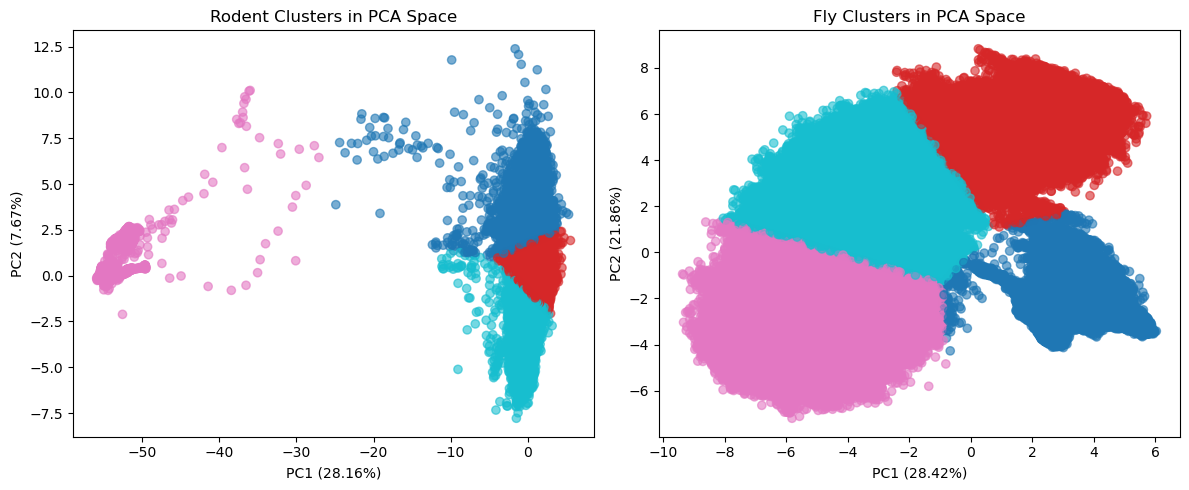

In [10]:
kmeans_rodent = KMeans(n_clusters=4, random_state=42).fit(pca_embedded_rodent)
rodent_labels = kmeans_rodent.labels_

kmeans_fly = KMeans(n_clusters=4, random_state=42).fit(pca_embedded_fly)
fly_labels = kmeans_fly.labels_

explained_var_rodent = pca_rodent.explained_variance_ratio_ * 100
explained_var_fly = pca_fly.explained_variance_ratio_ * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(pca_embedded_rodent[:, 0], pca_embedded_rodent[:, 1], 
                c=rodent_labels, cmap='tab10', alpha=0.6)
axes[0].set_title("Rodent Clusters in PCA Space")
axes[0].set_xlabel(f"PC1 ({explained_var_rodent[0]:.2f}%)")
axes[0].set_ylabel(f"PC2 ({explained_var_rodent[1]:.2f}%)")

axes[1].scatter(pca_embedded_fly[:, 0], pca_embedded_fly[:, 1], 
                c=fly_labels, cmap='tab10', alpha=0.6)
axes[1].set_title("Fly Clusters in PCA Space")
axes[1].set_xlabel(f"PC1 ({explained_var_fly[0]:.2f}%)")
axes[1].set_ylabel(f"PC2 ({explained_var_fly[1]:.2f}%)")

plt.tight_layout()
plt.show()

We can also overlay both intentions onto the same subspace and examine the intersections

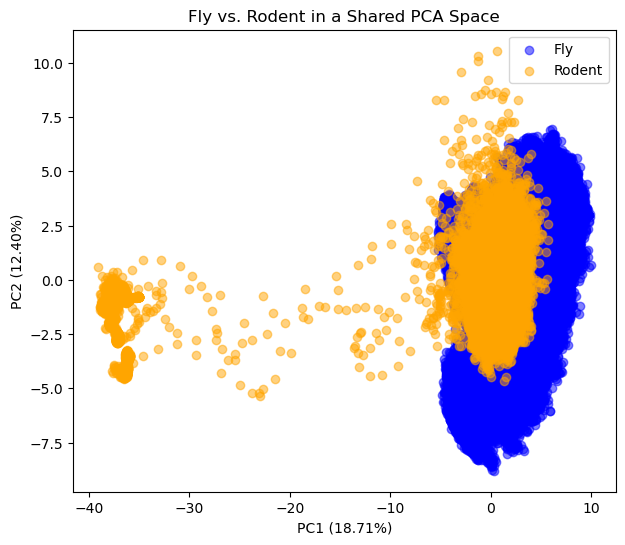

In [11]:
combined_data = np.vstack([intentions_rodent, intentions_fly])

pca_shared = PCA(n_components=2, random_state=42)
pca_shared.fit(combined_data)

fly_2d_shared = pca_shared.transform(intentions_fly)
rodent_2d_shared = pca_shared.transform(intentions_rodent)

explained_var_shared = pca_shared.explained_variance_ratio_ * 100

plt.figure(figsize=(7, 6))
plt.scatter(fly_2d_shared[:, 0], fly_2d_shared[:, 1], alpha=0.5, label="Fly", color="blue")
plt.scatter(rodent_2d_shared[:, 0], rodent_2d_shared[:, 1], alpha=0.5, label="Rodent", color="orange")

plt.title("Fly vs. Rodent in a Shared PCA Space")
plt.xlabel(f"PC1 ({explained_var_shared[0]:.2f}%)")
plt.ylabel(f"PC2 ({explained_var_shared[1]:.2f}%)")
plt.legend()
plt.show()

We can also conduct the same analysis on the activations of the rodent and the fly. For simplicity, we will render them on the same graph with 3 principal component and a 3D graph. We will need to load in all activation data first (this might take a while).

In [4]:
layers = [['encoder','layer_0'], ['encoder','layer_1'], ['decoder','layer_0'], ['decoder','layer_1']]
fly_activations = {}
rodent_activations = {}

work_fly = {tuple(layer): functools.partial(get_aggregate_data, "/activations", layer,
                                            path=fly_rollout_dir) for layer in layers}
work_rodent = {tuple(layer): functools.partial(get_aggregate_data, "/activations", layer,
                                               path=rodent_rollout_dir) for layer in layers}

with mp.Pool(processes=mp.cpu_count()) as pool:
    for layer in layers:
        layer_key = tuple(layer)
        activations_fly = list(tqdm(pool.imap(work_fly[layer_key], range(499)), total=499))
        activations_rodent = list(tqdm(pool.imap(work_rodent[layer_key], range(842)), total=842))
        fly_activations[layer_key] = np.vstack(activations_fly)
        rodent_activations[layer_key] = np.vstack(activations_rodent)

def process_and_plot_3d(activations, title, k, ax):
    """Performs PCA and K-Means clustering, then visualizes in 3D."""
    pca = PCA(n_components=3)
    pca_embedded = pca.fit_transform(activations)

    kmeans = KMeans(n_clusters=k, random_state=42).fit(pca_embedded)
    labels = kmeans.labels_

    sc = ax.scatter(
        pca_embedded[:, 0], pca_embedded[:, 1], pca_embedded[:, 2],
        c=labels, cmap="tab20", alpha=0.5
    )

    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
    ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.2f}%)")
    ax.set_title(title)

/root/miniforge3/envs/track_mjx/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 842/842 [00:19<00:00, 42.23it/s]
/root/miniforge3/envs/track_mjx/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


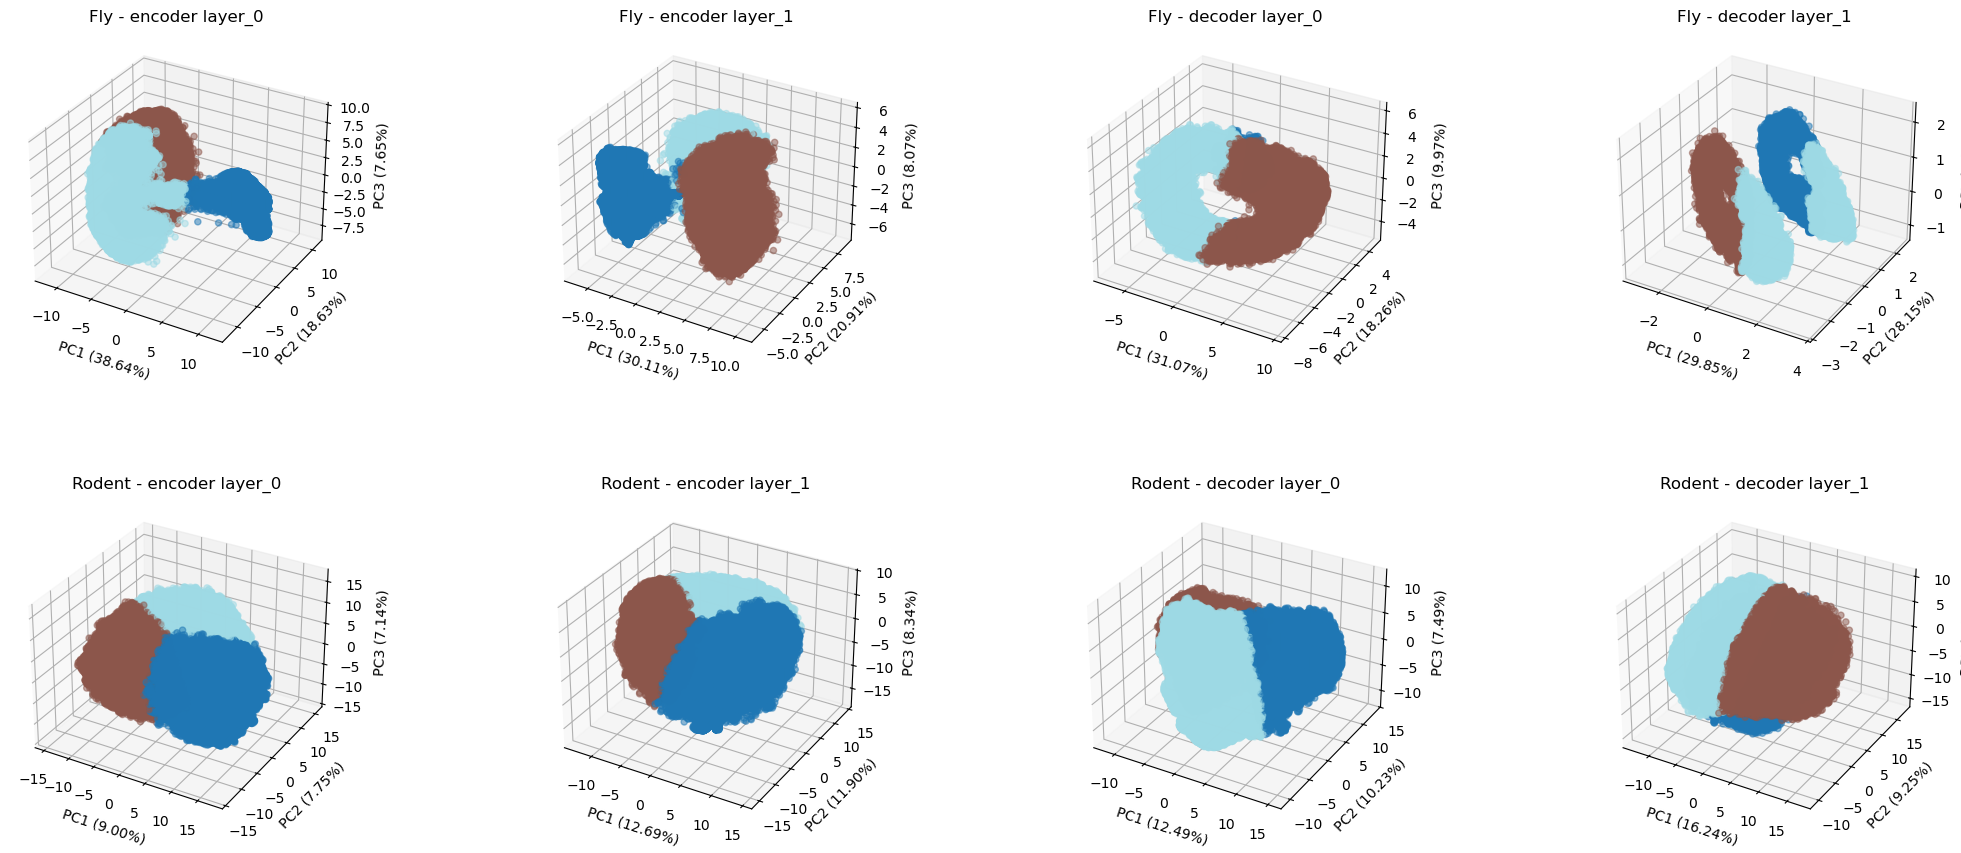

In [13]:
k = 3
fig, axes = plt.subplots(2, 4, figsize=(22, 10), subplot_kw={"projection": "3d"})
for i, layer in enumerate(layers):
    process_and_plot_3d(fly_activations[tuple(layer)], f"Fly - {layer[0]} {layer[1]}", k, axes[0, i])

for i, layer in enumerate(layers):
    process_and_plot_3d(rodent_activations[tuple(layer)], f"Rodent - {layer[0]} {layer[1]}", k, axes[1, i])

fig.subplots_adjust(left=0.05, right=0.95, top=0.90, bottom=0.10, wspace=0.35, hspace=0.40)
plt.show()

# 5. Topological data analysis

In [5]:
fly_activations[('encoder', 'layer_0')].shape

(498501, 256)

We can try to examine `persistent homology`, which try to reason with teh high dimensional structure space, seeing if there are connected components (H0), cyclic loops (H1), and voids (H2)

- These are activation data analysis, not bahaviors directly, but it entell about behaviors

`Filtration` is the process of building up a topological space by adding edges, triangles, and higher-dimensional simplices as a function of a parameter.

- At small filtration values, the data appears as discrete points. At small filtration values, the data appears as discrete points (each one its own connected component).

- As filtration grows, points start forming edges and loops.

- At larger filtration values, cycles get filled in, and higher-dimensional voids disappear.

The `diagonal line (y=x)` is the trivial persistence threshold.

- Any feature close to this line disappears quickly, meaning it does not persist.

- These features are usually noise.

In [6]:
layer_idx = ('encoder', 'layer_0')

Explained variance (Fly): 0.4518
Explained variance (Rodent): 0.4518


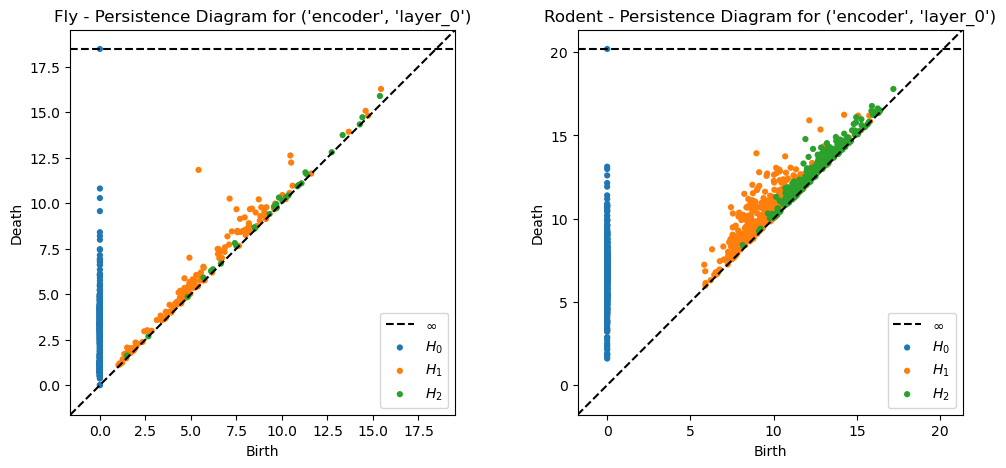

In [7]:
plot_homology(fly_activations, rodent_activations, layer_idx, 500)

- For H0, their birth values are near zero because they start as singletons. Their death values vary depending on when they merge with another component.

    - The tallest last one blue dot represents the last remaining component, which persists until all clusters merge into one.

- For H1 & H2, the rodent seems to have more (specifically H3 voids) cyclic behaviors and transitions between behaviors.

Explained variance (Fly): 0.4411
Explained variance (Rodent): 0.4411


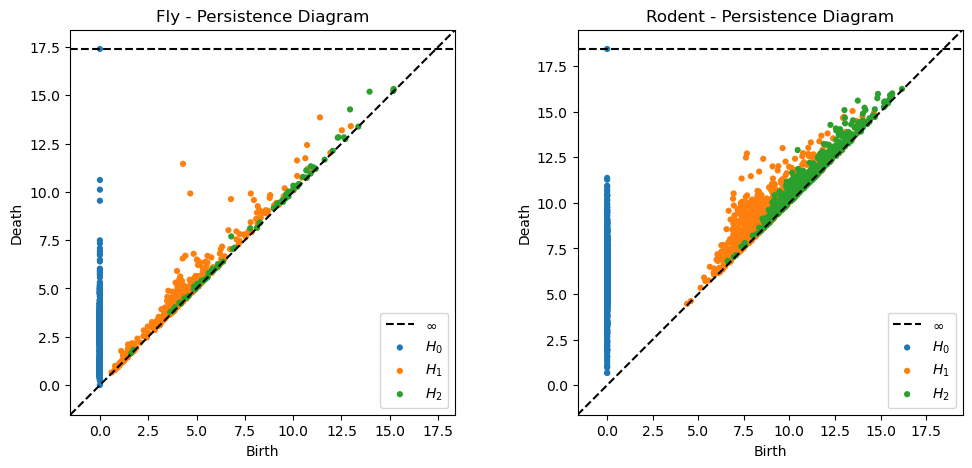

In [13]:
plot_homology(fly_activations, rodent_activations, layer_idx, 1000)

Explained variance (Fly): 0.4411
Explained variance (Rodent): 0.4411


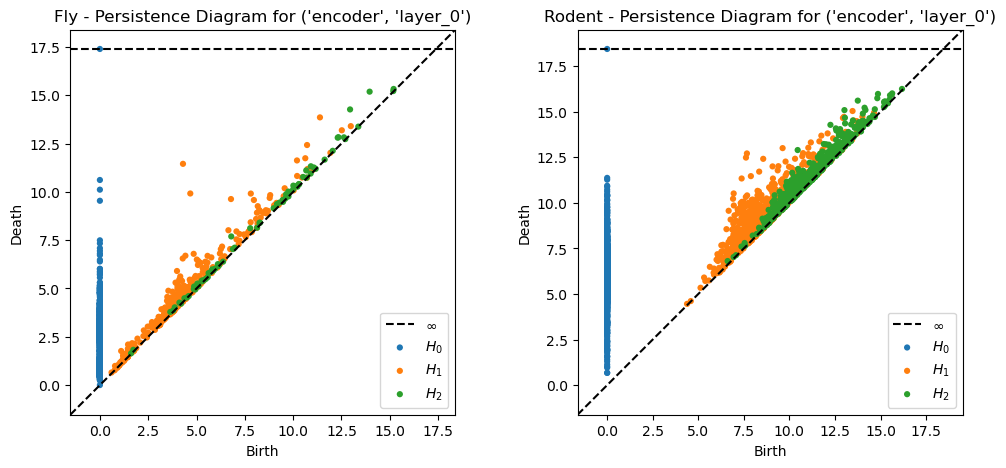

Explained variance (Fly): 0.4594
Explained variance (Rodent): 0.4594


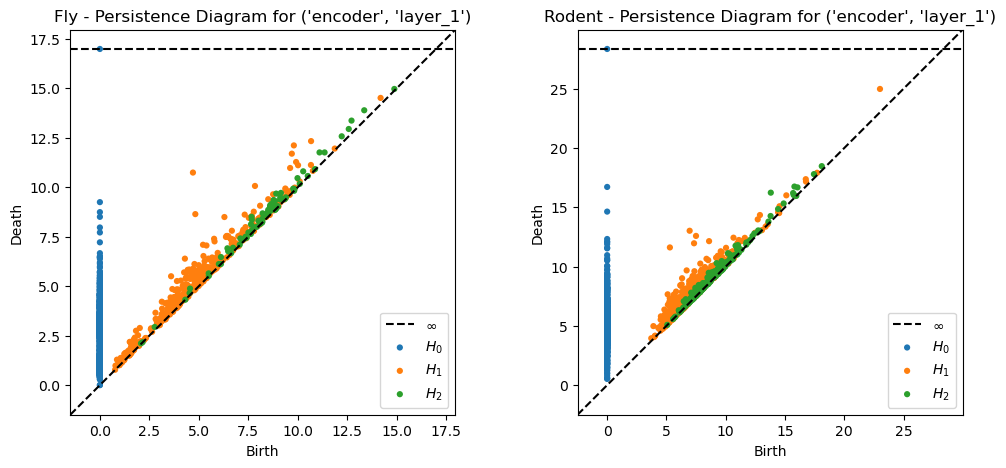

Explained variance (Fly): 0.4453
Explained variance (Rodent): 0.4453


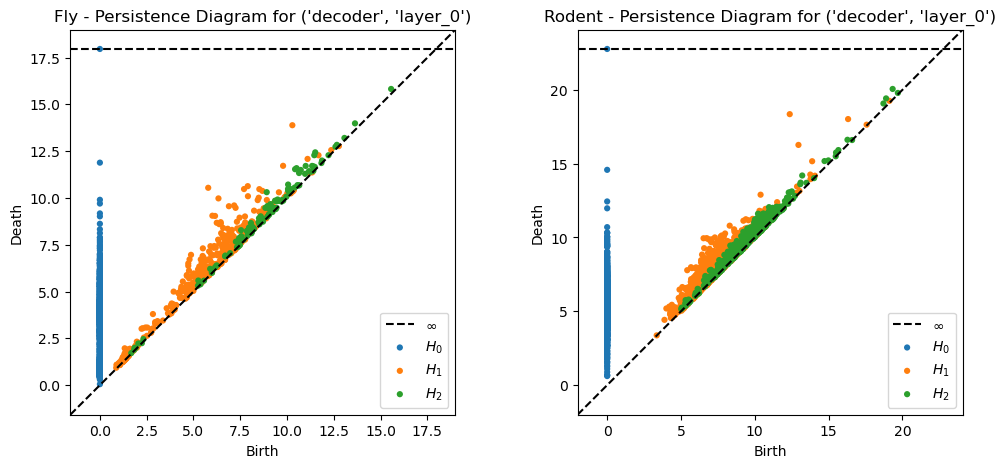

Explained variance (Fly): 0.4262
Explained variance (Rodent): 0.4262


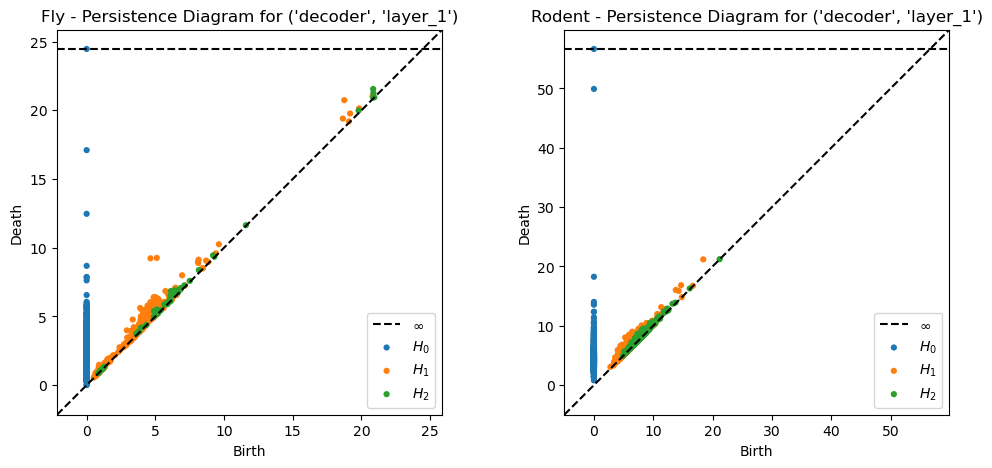

In [8]:
layers = [('encoder','layer_0'), ('encoder','layer_1'), ('decoder','layer_0'), ('decoder','layer_1')]
for i, layer in enumerate(layers):
    plot_homology(fly_activations, rodent_activations, layer, 1000)

Estimated Intrinsic Dimensionality: Fly=1.07, Rodent=1.03


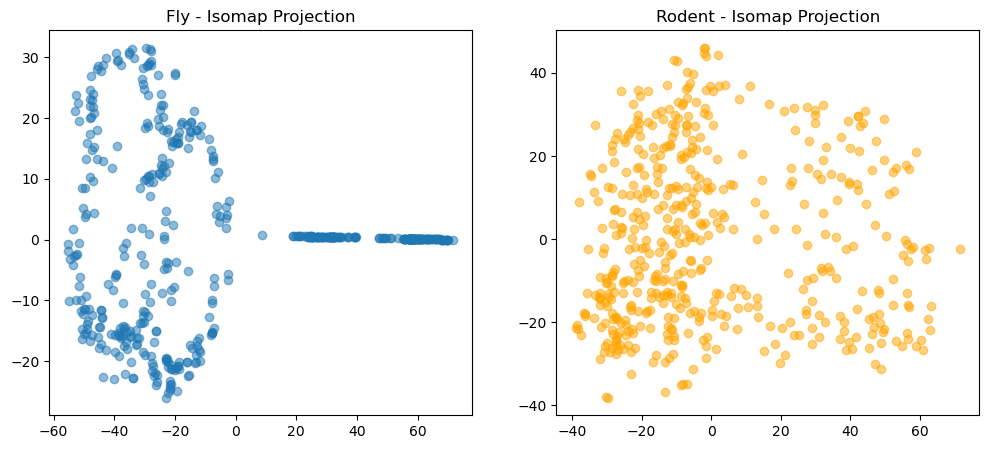

In [11]:
plot_intrinsic(fly_activations, rodent_activations, layer, 500)

# Step 6. Clustering then tagging behaviors

We can conduct behavior clustering based on labels of the clips and an majority vote mechanism

In [37]:
with open("/root/vast/scott-yang/vnl_ray/clips/all_snips.p", "rb") as file:
    all_snips = pkl.load(file)

/tmp/ipykernel_66213/161040515.py:2: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  all_snips = pkl.load(file)
/tmp/ipykernel_66213/161040515.py:2: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  all_snips = pkl.load(file)
/tmp/ipykernel_66213/161040515.py:2: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  all_snips = pkl.load(file)
/tmp/ipykernel_66213/161040515.py:2: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  all_snips = pkl.load(fi

In [38]:
all_labels = []
all_clip_ids = []

for path in all_snips["snips_order"]:
    behavior, clip_id = extract_clip_info(path)
    all_labels.append(behavior)
    all_clip_ids.append(clip_id)

all_labels = np.array(all_labels)
all_clip_ids = np.array(all_clip_ids)

num_clips = len(all_clip_ids)
frames_per_clip = 499
expanded_labels = np.repeat(all_labels, frames_per_clip)
expanded_clip_ids = np.repeat(all_clip_ids, frames_per_clip)

Explained variance: PC1 = 28.16%, PC2 = 7.67%
Cluster 0 → Assigned Behavior: Rear
Cluster 1 → Assigned Behavior: FaceGroom
Cluster 2 → Assigned Behavior: RGroom
Cluster 3 → Assigned Behavior: FastWalk


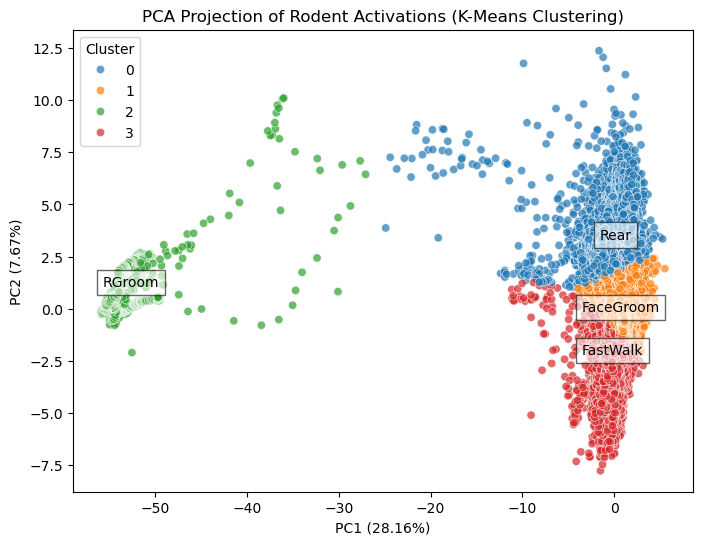

In [39]:
k = 4
var_explained = pca_rodent.explained_variance_ratio_ * 100
print(f"Explained variance: PC1 = {var_explained[0]:.2f}%, PC2 = {var_explained[1]:.2f}%")

kmeans = KMeans(n_clusters=k, random_state=42)
cluster_ids = kmeans.fit_predict(pca_embedded_rodent)

# Compute majority behavior for each cluster
cluster_to_behavior = {i: [] for i in range(k)}
for i, cluster in enumerate(cluster_ids):
    cluster_to_behavior[cluster].append(expanded_labels[i]) 

cluster_majority_behavior = {}
for cluster, behaviors in cluster_to_behavior.items():
    # Get most frequent behavior
    most_common_behavior = Counter(behaviors).most_common(1)[0][0]
    cluster_majority_behavior[cluster] = most_common_behavior
    print(f"Cluster {cluster} → Assigned Behavior: {most_common_behavior}")

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_embedded_rodent[:, 0], y=pca_embedded_rodent[:, 1], hue=cluster_ids, palette="tab10", alpha=0.7)
plt.title("PCA Projection of Rodent Activations (K-Means Clustering)")
plt.xlabel(f"PC1 ({var_explained[0]:.2f}%)")
plt.ylabel(f"PC2 ({var_explained[1]:.2f}%)")
for cluster, behavior in cluster_majority_behavior.items():
    cluster_center = np.mean(pca_embedded_rodent[cluster_ids == cluster], axis=0)
    plt.text(cluster_center[0], cluster_center[1], behavior, fontsize=10, ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))

plt.legend(title="Cluster")
plt.show()

# Step 7. PCA clustering with Mujoco rendering

We have also created functions in which we can render the global PCA graph (PCA across al clips) +  local PCA graph (PCA for one single clip) among rendering with Mujoco.

In [40]:
clip_id = 1
clip_length = 599
start = clip_id * clip_length 
end = start + clip_length
global_subset_indices = np.arange(start, end)

with h5py.File(fly_rollout_dir + f"/clip_{clip_id}.h5", "r") as h5file:
    rollout = load_from_h5py(h5file)
    act = get_aggregate_data("/activations", ['intention'], clip_id, path=fly_rollout_dir)

act = act[:599] # ref only have 600
act = scaler.fit_transform(act)
intentions_fly = scaler.fit_transform(intentions_fly)

pca_global = PCA(n_components=2, random_state=42)
pca_local = PCA(n_components=2, random_state=42)
global_embedding = pca_global.fit(intentions_fly).transform(intentions_fly)
local_embedding = pca_local.fit(act).transform(act)
global_labels = KMeans(n_clusters=4, random_state=42).fit(global_embedding).labels_
local_labels = KMeans(n_clusters=4, random_state=42).fit(local_embedding).labels_

frames = render_with_global_and_local_pca_progression(
    rollout=rollout,
    walker_name="fly",
    pca_global=global_embedding, 
    cluster_global=global_labels,
    global_subset_indices=global_subset_indices,
    pca_local=local_embedding,
    cluster_local=local_labels,
    var_lcoal=pca_global.explained_variance_ratio_,
    var_global=pca_local.explained_variance_ratio_,
)
display_video(frames, framerate=50)

MuJoCo Rendering...


 60%|██████    | 600/1000 [00:03<00:02, 159.12it/s]


Rendering PCA (global+local) progression...


/root/miniforge3/envs/track_mjx/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/vast/kaiwen/track-mjx/track_mjx/analysis/render.py:452: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(height, width, 3)
/root/vast/kaiwen/track-mjx/track_mjx/analysis/render.py:452: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(height, width, 3)
/root/vast/kaiwen/track-mjx/track_mjx/analysis/render.py:452: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.

In [41]:
clip_id = 1
clip_length = 499
start = clip_id * clip_length 
end = start + clip_length
global_subset_indices = np.arange(start, end)

with h5py.File(rodent_rollout_dir + f"/clip_{clip_id}.h5", "r") as h5file:
    rollout = load_from_h5py(h5file)
    act = get_aggregate_data("/activations", ['intention'], clip_id, path=rodent_rollout_dir)

act = scaler.fit_transform(act)
intention_rodent = scaler.fit_transform(intentions_rodent)

pca_global = PCA(n_components=2, random_state=42)
pca_local = PCA(n_components=2, random_state=42)
global_embedding = pca_global.fit(intention_rodent).transform(intention_rodent)
local_embedding = pca_local.fit(act).transform(act)
global_labels = KMeans(n_clusters=4, random_state=42).fit(global_embedding).labels_
local_labels = KMeans(n_clusters=4, random_state=42).fit(local_embedding).labels_

frames = render_with_global_and_local_pca_progression(
    rollout=rollout,
    walker_name="rodent",
    pca_global=global_embedding, 
    cluster_global=global_labels,
    global_subset_indices=global_subset_indices,
    pca_local=local_embedding,
    cluster_local=local_labels,
    var_lcoal=pca_fly.explained_variance_ratio_,
    var_global=pca_local.explained_variance_ratio_,
)
display_video(frames, framerate=50)

MuJoCo Rendering...


100%|██████████| 500/500 [00:03<00:00, 145.84it/s]


Rendering PCA (global+local) progression...


/root/miniforge3/envs/track_mjx/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/vast/kaiwen/track-mjx/track_mjx/analysis/render.py:452: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(height, width, 3)
/root/vast/kaiwen/track-mjx/track_mjx/analysis/render.py:452: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(height, width, 3)
/root/vast/kaiwen/track-mjx/track_mjx/analysis/render.py:452: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.

# Step 8. Visualizing Gait Cycles

We can visualize the gait cycle of each of the virtuak rodent, just like activation, we can load in the qposes for each first.

In [5]:
work_fly = functools.partial(get_aggregate_data, "/qposes_rollout", [], path=fly_rollout_dir)
work_rodent = functools.partial(get_aggregate_data, "/qposes_rollout", [], path=rodent_rollout_dir)

with mp.Pool(processes=mp.cpu_count()) as pool:
    qpos_fly = list(tqdm(pool.imap(work_fly, range(30)), total=30))
    qpos_rodent = list(tqdm(pool.imap(work_rodent, range(1, 842)), total=841))

qpos_fly = np.vstack(qpos_fly)
qpos_rodent = np.vstack(qpos_rodent)

/root/miniforge3/envs/track_mjx/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 841/841 [00:00<00:00, 2001.85it/s]


In [6]:
work_fly = functools.partial(get_aggregate_data, "/ctrl", [], path=fly_rollout_dir)
work_rodent = functools.partial(get_aggregate_data, "/ctrl", [], path=rodent_rollout_dir)

with mp.Pool(processes=mp.cpu_count()) as pool:
    ctrl_fly = list(tqdm(pool.imap(work_fly, range(30)), total=30))
    ctrl_rodent = list(tqdm(pool.imap(work_rodent, range(1, 842)), total=841))

ctrl_fly = np.vstack(ctrl_fly)
ctrl_rodent = np.vstack(ctrl_rodent)

100%|██████████| 841/841 [00:01<00:00, 432.27it/s]


Let's look at a heigh based gait cycle analysis

In [13]:
# fly_leg_indices = [6, 12, 18, 24, 30, 36]
# fly_leg_labels = ["Front Leg (T1) Left", "Front Leg (T1) Right",
#                   "Middle Leg (T2) Left", "Middle Leg (T2) Right",
#                   "Hind Leg (T3) Left", "Hind Leg (T3) Right"]
# plot_height_based_gait_analysis(qpos_fly, fly_leg_indices, fly_leg_labels, dt=1/500, 
#                               clip_start=0, num_clips=3, timesteps_per_clip=599, 
#                               color='blue', title_prefix="Fly - Gait Analysis")

# rodent_leg_indices = [12, 18, 59, 67]
# rodent_leg_labels = ["Hind Left (Toe)", "Hind Right (Toe)", "Fore Left (Finger)", "Fore Right (Finger)"]
# plot_height_based_gait_analysis(qpos_rodent, rodent_leg_indices, rodent_leg_labels, dt=1/50, 
#                               clip_start=0, num_clips=3, timesteps_per_clip=250, 
#                               color='red', title_prefix="Rodent - Gait Analysis")

And finally to the joint forces based

In [14]:
# joint_forces_fly = estimate_joint_forces_parallel(qpos_fly, dt=0.002, walker_type='fly')
# leg_joint_indices = [6, 12, 18, 24, 30, 36]
# fly_leg_forces = joint_forces_fly[:, leg_joint_indices]

# plot_force_based_gait_analysis(
#     joint_forces=fly_leg_forces,  
#     leg_labels=["Front Left", "Front Right", "Mid Left", "Mid Right", "Hind Left", "Hind Right"],
#     dt=1/500, 
#     clip_start=0, 
#     num_clips=5, 
#     timesteps_per_clip=599, 
#     color='purple', 
#     title_prefix="Fly - Joint Force Gait Analysis",
#     contact_threshold=50
# )

In [15]:
# joint_forces_rodent = estimate_joint_forces_parallel(qpos_rodent, dt=0.02,  walker_type='rodent')
# leg_joint_indices = [12, 18, 59, 67]
# rodent_leg_forces = joint_forces_rodent[:, leg_joint_indices]

# plot_force_based_gait_analysis(
#     joint_forces=rodent_leg_forces,  
#     leg_labels=["Hind Left (Toe)", "Hind Right (Toe)", "Fore Left (Finger)", "Fore Right (Finger)"],
#     dt=1/50, 
#     clip_start=0, 
#     num_clips=5, 
#     timesteps_per_clip=250, 
#     color='purple', 
#     title_prefix="Rodent - Joint Force Gait Analysis",
#     contact_threshold=1
# )

Now let's check one with ground forces analysis

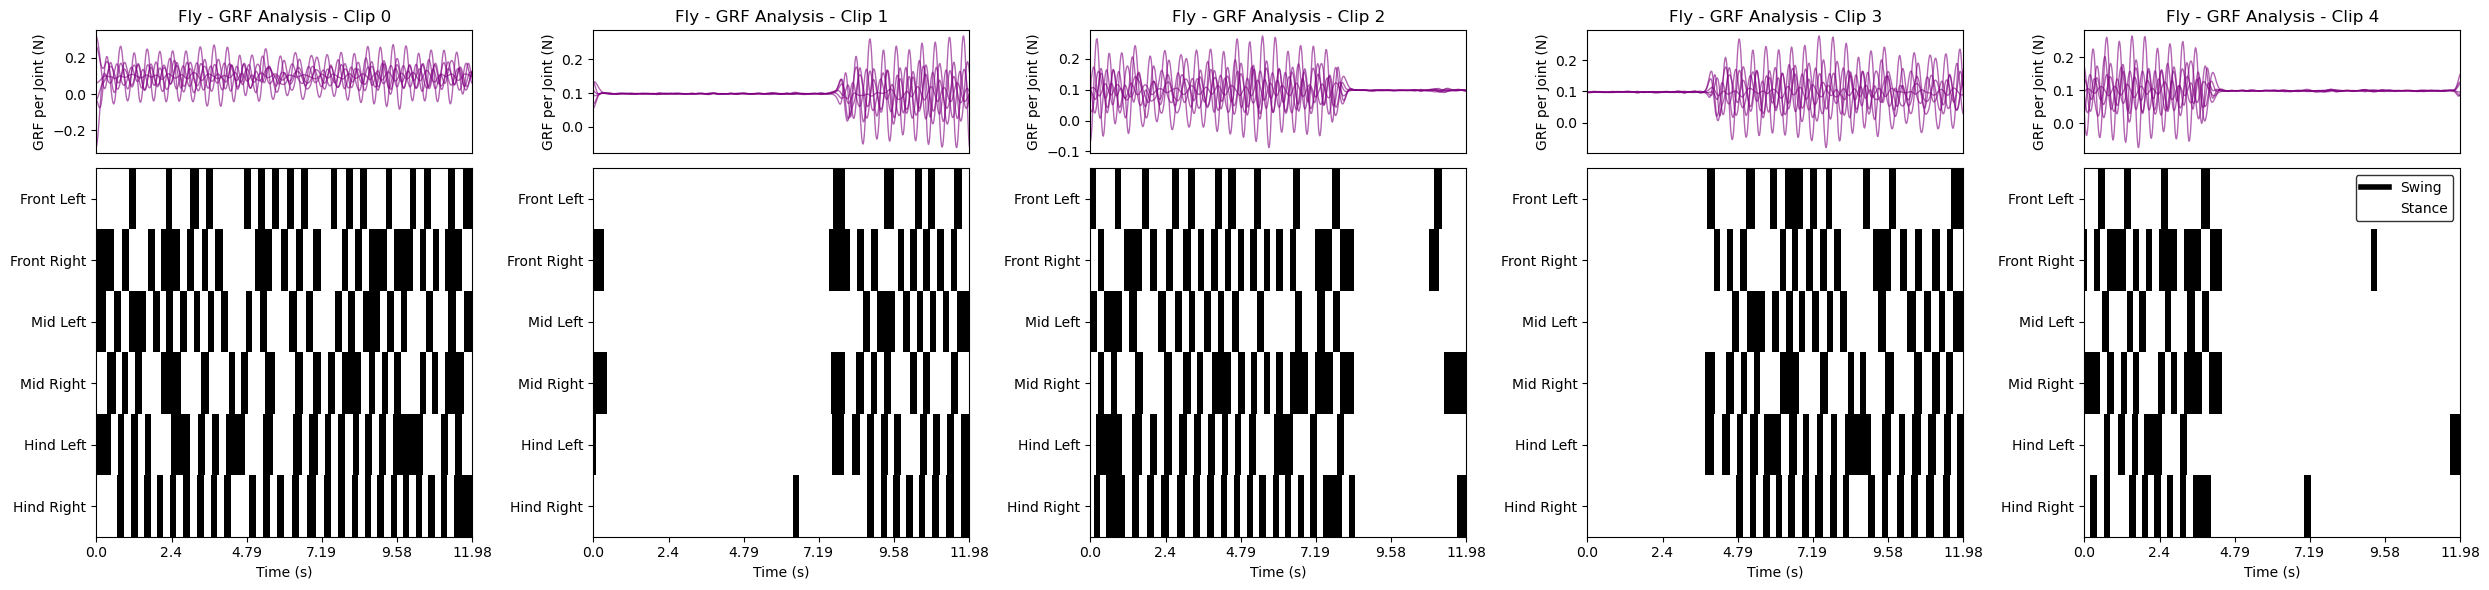

In [44]:
leg_joint_indices = [6, 12, 18, 24, 30, 36]
ground_forces_per_joint = estimate_ground_forces_per_joint(qpos_fly, dt=0.02, mass_per_joint=np.ones(len(leg_joint_indices)) * 0.01, z_indices=leg_joint_indices)

plot_grf_based_gait_analysis_per_joint(
    ground_forces_per_joint,
    leg_labels=["Front Left", "Front Right", "Mid Left", "Mid Right", "Hind Left", "Hind Right"], 
    dt=0.02, 
    clip_start=0, 
    num_clips=5, 
    timesteps_per_clip=599, 
    color='purple', 
    title_prefix="Fly - GRF Analysis", 
    contact_threshold=0.1
)

In [16]:
# plt.figure(figsize=(10, 5))
# for i in range(ground_forces_per_joint.shape[1]):
#     plt.plot(ground_forces_per_joint[:, i], label=f"Joint {i}")
# plt.legend()
# plt.xlabel("Time")
# plt.ylabel("GRF (N)")
# plt.title("Ground Reaction Forces per Joint")
# plt.show()


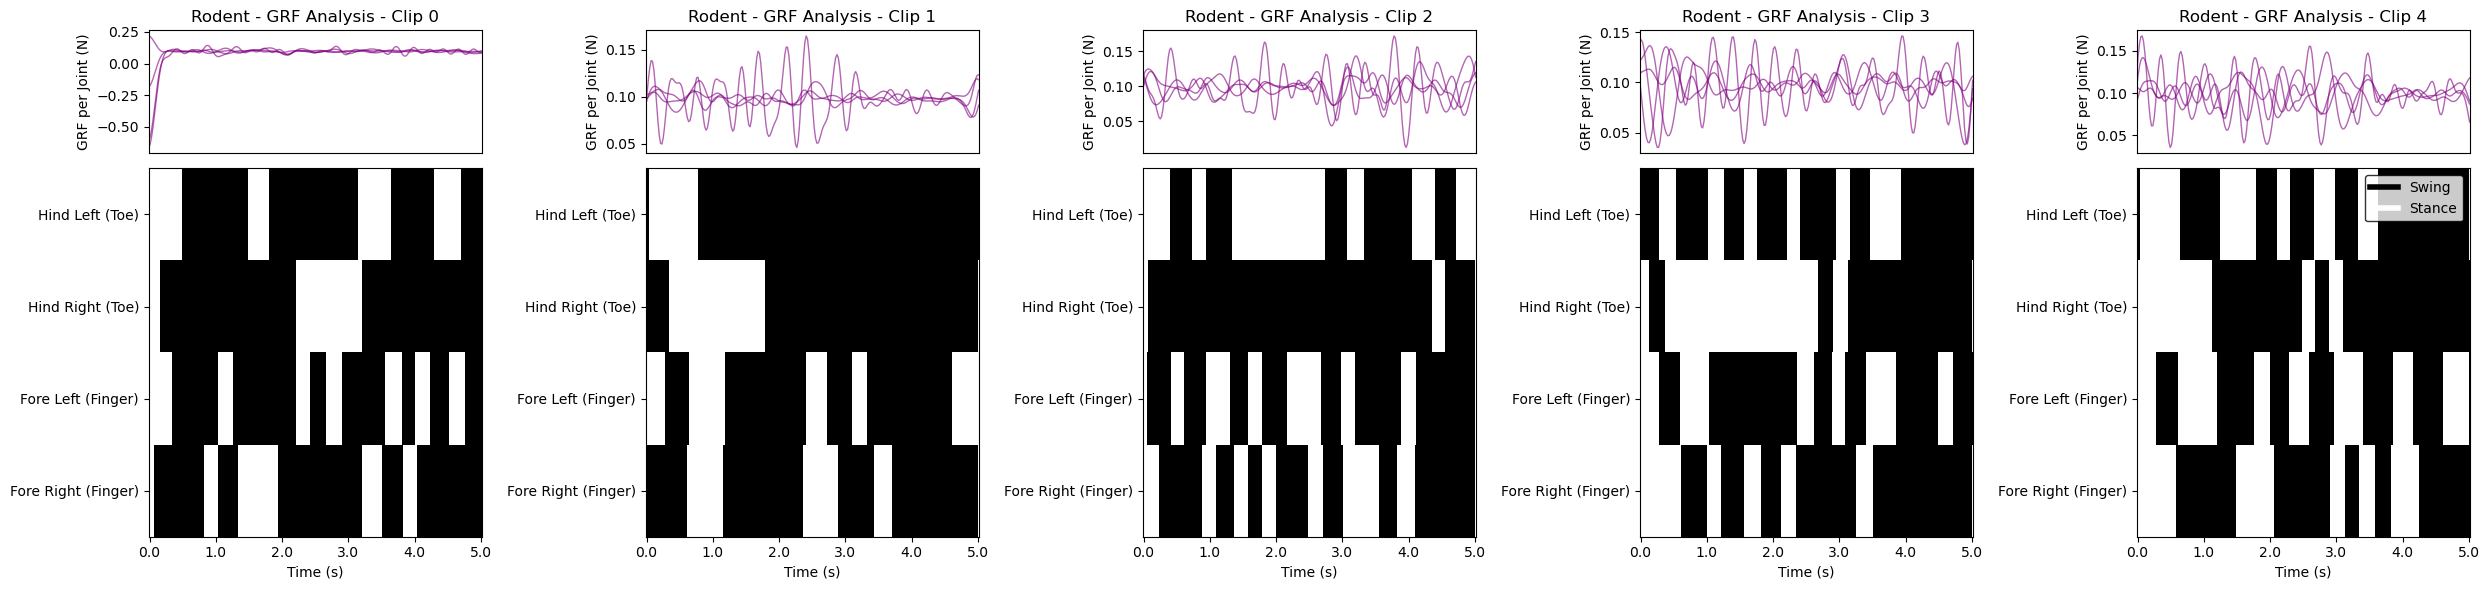

In [30]:
leg_joint_indices = [12, 18, 59, 67]
ground_forces_per_joint = estimate_ground_forces_per_joint(qpos_rodent, dt=1/50, mass_per_joint=np.ones(len(leg_joint_indices)) * 0.01, z_indices=leg_joint_indices)

plot_grf_based_gait_analysis_per_joint(
    ground_forces_per_joint,
    leg_labels=["Hind Left (Toe)", "Hind Right (Toe)", "Fore Left (Finger)", "Fore Right (Finger)"],
    dt=1/50, 
    clip_start=0, 
    num_clips=5, 
    timesteps_per_clip=250, 
    color='purple', 
    title_prefix="Rodent - GRF Analysis", 
    contact_threshold=3
)

In [17]:
# plt.figure(figsize=(10, 5))
# for i in range(ground_forces_per_joint.shape[1]):
#     plt.plot(ground_forces_per_joint[:, i], label=f"Joint {i}")
# plt.legend()
# plt.xlabel("Time")
# plt.ylabel("GRF (N)")
# plt.title("Ground Reaction Forces per Joint")
# plt.show()

In [11]:
nclips=841
ctrl_force = ctrl_rodent.reshape(nclips, ctrl_rodent.shape[1], -1, 3)

ctrl_force[np.abs(ctrl_force)<1e-4]=0
ctrl_force_clip = ctrl_force.copy()
print(ctrl_force_clip.shape) # nclips x timesteps x sensor x xyz
N = 10 # Mean filter kernel size
ctrl_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(N), mode='same'), axis=1, arr=ctrl_force_clip)
ctrl_binary = np.zeros_like(ctrl_smooth)
ctrl_binary[np.abs(ctrl_smooth)>0.01] = 1

def find_onsets_offsets(signal, threshold=0.5):
    """
    Finds the onsets and offsets of a square signal.

    Args:
        signal: The input signal (numpy array).
        threshold: The threshold for determining onsets and offsets (default: 0.5).

    Returns:
        onsets: A list of indices corresponding to the onsets.
        offsets: A list of indices corresponding to the offsets.
    """

    onsets = []
    offsets = []

    state = 0  # 0: low, 1: high

    for i, value in enumerate(signal):
        if state == 0 and value > threshold:
            onsets.append(i)
            state = 1
        elif state == 1 and value < threshold:
            offsets.append(i)
            state = 0

    return onsets, offsets

def calculate_peakforces(sdata_binary,sdata):
    onsets_all,offsets_all = [],[]
    for clip_idx in range(sdata_binary.shape[0]):
        clip_onsets, clip_offsets = [],[]
        for end_eff_idx in range(sdata_binary.shape[2]):
            dim_onsets, dim_offsets = [],[]
            for dim in range(sdata_binary.shape[3]):
                onsets, offsets = find_onsets_offsets(sdata_binary[clip_idx,:,end_eff_idx,dim])
                dim_onsets.append(onsets)
                dim_offsets.append(offsets)
            clip_onsets.append(dim_onsets)
            clip_offsets.append(dim_offsets)
        onsets_all.append(clip_onsets)
        offsets_all.append(clip_offsets)
        
    sdata_square = np.zeros_like(sdata)
    sdata_square.shape
    peak_force_all,peak_force_all_std = [],[]
    for clip_idx,(clip_onsets,clip_offsets) in enumerate(zip(onsets_all,offsets_all)):
        peak_force_end_eff,peak_force_end_eff_std = [],[]
        for end_eff_idx,(end_eff_onsets,end_eff_offsets) in enumerate(zip(clip_onsets,clip_offsets)):
            peak_force_dim, peak_force_std = [], []
            for dim,(dim_on,dim_off) in enumerate(zip(end_eff_onsets,end_eff_offsets)):
                peak_force = []
                for on,off in zip(dim_on,dim_off):
                    if off-on<10:
                        # print(on,off)
                        continue
                    else:
                        sign = np.sign(np.mean(sdata[clip_idx,on:off,end_eff_idx,dim]))
                        sdata_square[clip_idx,on:off,end_eff_idx,dim] = sign * np.nanmean(np.abs(sdata[clip_idx,on:off,end_eff_idx,dim]))
                        peak_force.append(np.nanmean(np.abs(sdata[clip_idx,on:off,end_eff_idx,dim])))
                peak_force_dim.append(np.nanmean(peak_force))
                peak_force_std.append(np.nanstd(peak_force))
            peak_force_end_eff.append(peak_force_dim)
            peak_force_end_eff_std.append(peak_force_std)
        peak_force_all.append(peak_force_end_eff)
        peak_force_all_std.append(peak_force_end_eff_std)
    peak_force_all = np.stack(peak_force_all)
    peak_force_all_std = np.stack(peak_force_all_std)
    return peak_force_all, peak_force_all_std, sdata_square

peak_force_ctrl,peak_force_ctrl_std, ctrl_square = calculate_peakforces(ctrl_binary, ctrl_force_clip)
ctrl_mean_peak_force = np.nanmean(peak_force_ctrl,axis=0)
ctrl_std_peak_force = np.nanstd(peak_force_ctrl_std,axis=(0))
clip_idx = 1
end_eff_idx = 1
dim = 1
N = 10

ctrl_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(N)/N, mode='full'), axis=1, arr=ctrl_force_clip)
ctrl_binary = np.zeros_like(ctrl_smooth)
ctrl_binary[np.abs(ctrl_smooth)>0.01] = 1
plt.plot(ctrl_force_clip[clip_idx,:,end_eff_idx,dim])
plt.plot(ctrl_smooth[clip_idx,:,end_eff_idx,dim])
plt.plot(ctrl_binary[clip_idx,:,end_eff_idx,dim])
plt.plot(ctrl_square[clip_idx,:,end_eff_idx,dim])

ValueError: cannot reshape array of size 15947042 into shape (842,38,newaxis,3)